## Installing Necessary Packages

In [80]:
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install -U colabgymrender &> /dev/null
!pip install imageio==2.4.1 &> /dev/null
!pip install --upgrade AutoROM &> /dev/null
!AutoROM --accept-license &> /dev/null
!pip install gym[atari,accept-rom-license] &> /dev/null

## Importing Necessary Packages

In [81]:
import gym
import os
import torch
import random
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as f
from collections import namedtuple, deque
%matplotlib inline
from IPython import display as ipythondisplay
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Hyperparameters

In [82]:
BATCH_SIZE = 128
BUFFER_SIZE = 1000000
GAMMA = 0.99
LR = 0.00025
FREQUENCY = 5
TAU = 0.005

## Replay Buffer (Store <state, action, reward, next_state, done>)

In [83]:
class ReplayBuffer:

  def __init__(self, action_size, buffer_size, batch_size, seed):
    self.action_size = action_size
    self.memory = deque(maxlen=buffer_size)
    self.batch_size = batch_size

    self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    self.seed = random.seed(seed)

  def add(self, state, action, reward, next_state, done):
    self.memory.append(self.experience(state, action, reward, next_state, done))

  def sample(self):
    experience = random.sample(self.memory, k=self.batch_size)

    states = torch.from_numpy(np.vstack([i.state for i in experience if i is not None])).float()
    actions = torch.from_numpy(np.vstack([i.action for i in experience if i is not None])).float()
    rewards = torch.from_numpy(np.vstack([i.reward for i in experience if i is not None])).float()
    next_states = torch.from_numpy(np.vstack([i.next_state for i in experience if i is not None])).float()
    dones = torch.from_numpy(np.vstack([i.done for i in experience if i is not None]).astype(np.uint8)).float()

    return (states, actions, rewards, next_states, dones)

  def __len__(self):
    return len(self.memory)


## Newtork Type 1 (Mean Advantage)

In [84]:
class QNetworkType1(nn.Module):

  def __init__(self, state_size, action_size, seed):
    super(QNetworkType1, self).__init__()
    self.seed = torch.manual_seed(seed)

    self.layer1 = nn.Linear(state_size, 128)
    self.layer2 = nn.Linear(128, 128)

    self.value_function = nn.Linear(128, 1)

    self.advantage = nn.Linear(128, action_size)

  def forward(self, state):

    x = f.relu(self.layer2(f.relu(self.layer1(state))))
    value_function = self.value_function(x)
    advantage = self.advantage(x)

    return value_function + (advantage-advantage.mean(dim=1, keepdim=True))

## Network Type 2 (Max Advantage)

In [85]:
class QNetworkType2(nn.Module):

  def __init__(self, state_size, action_size, seed):
    super(QNetworkType2, self).__init__()
    self.seed = torch.manual_seed(seed)

    self.layer1 = nn.Linear(state_size, 128)
    self.layer2 = nn.Linear(128, 128)

    self.value_function = nn.Linear(128, 1)

    self.advantage = nn.Linear(128, action_size)

  def forward(self, state):

    x = f.relu(self.layer2(f.relu(self.layer1(state))))
    value_function = self.value_function(x)
    advantage = self.advantage(x)

    return value_function + (advantage-advantage.max(dim=1, keepdim=True)[0])

## Agent

In [86]:
class Agent():
  def __init__(self, state_size, action_size, seed, qnetwork = QNetworkType1):
    self.state_size = state_size
    self.action_size = action_size
    self.seed = random.seed(seed)

    self.qnetworkPrimary = qnetwork(state_size, action_size, seed)
    self.qnetworkTarget = qnetwork(state_size, action_size, seed)

    self.optimizer = optim.Adam(self.qnetworkPrimary.parameters(), lr=LR)

    self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
    self.timestep = 0

  def step(self, state, action, reward, next_state, done):
    self.memory.add(state, action, reward, next_state, done)

    self.timestep = (self.timestep + 1) % FREQUENCY
    if self.timestep == 0:
      if len(self.memory) > BATCH_SIZE:
        experiences = self.memory.sample()
        self.learn(experiences, GAMMA)

  def learn(self, experience, gamma):
    states, actions, rewards, next_states, dones = experience

    q_nextTarget = self.qnetworkTarget(next_states).detach().max(1)[0].unsqueeze(1)
    actions = actions.type(torch.int64)
    q_Target = rewards + (gamma*q_nextTarget*(1-dones))
    q_Expected = self.qnetworkPrimary(states).gather(1, actions)

    loss = f.mse_loss(q_Expected, q_Target)

    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    self.update(self.qnetworkPrimary, self.qnetworkTarget, TAU)

  def update(self, primaryNetwork, targetNetwork, tau):

    for target_param, local_param in zip(targetNetwork.parameters(), primaryNetwork.parameters()):
      target_param.data.copy_(tau*local_param.data + (1 - tau)*target_param.data)

  def move(self, state, eps=0):
    state = torch.from_numpy(state).float().unsqueeze(0)
    self.qnetworkPrimary.eval()
    with torch.no_grad():
      action_values = self.qnetworkPrimary(state)
    self.qnetworkPrimary.train()

    if random.random() > eps:
      return np.argmax(action_values.data.numpy())
    else:
      return random.choice(np.arange(self.action_size))

## Dueling DQN 

In [87]:
def duelingDQN(agent, episodes = 2000, max_timestep = 1000, ep_start = 1.0, ep_end = 0.001, ep_decay = 0.9975, exp_no = 3):
  scores= []
  scores_window = deque(maxlen = 100)
  epsilon = ep_start

  for episode in range(1, episodes+1):
    state = env.reset()
    score = 0

    for t in range(max_timestep):
      action = agent.move(state, epsilon)
      next_state, reward, done, _ = env.step(action)
      agent.step(state, action, reward, next_state, done)
      score+=reward
      state = next_state
      if done:
        break

    scores_window.append(score)
    scores.append(score)
    epsilon = max(ep_end, ep_decay*epsilon)

    # print(f'Episode {episode}    Average Score: {np.mean(scores_window)}')
    if episode % 100 == 0:
      print(f'Episode {episode}    Average Score: {np.mean(scores_window)}')
    if np.mean(scores_window) >= env.spec.reward_threshold:
      print(f"Environment solved in {episode} episodes !!!!   Average Score: {np.mean(scores_window)}")
      file_name = 'acrobot_model_weights'+str(exp_no)+'.pth'
      torch.save(agent.qnetworkPrimary.state_dict(), file_name)
      break

  return scores

## Multiple Seed 

In [88]:
def multiple_experiments(agent, num_seeds=5, exp_no = 1):
    all_scores = []
    min_length = float('inf')

    for seed in range(num_seeds):
        print(f"\nTraining with seed {seed+1}\n")
        env.seed(seed)
        scores = duelingDQN(agent=agent, exp_no = exp_no)
        all_scores.append(scores)

        min_length = min(min_length, len(scores))
    # Calculate the average scores across all seeds for each episode

    all_scores_dim = [score[:min_length] for score in all_scores]
    return all_scores_dim

## Experiment 1: Acrobot - Type 1 

In [89]:
print("######## Experiment 1: Dueling DQN Type 1 ############\n")
print("######## Environment 1: Acrobot ############")
print(" ")
env = gym.make('Acrobot-v1')
env.seed(0)

print(f"Observation Space: {env.observation_space}\n")
print(f"Observation Space Shape: {env.observation_space.shape}\n")
print(f"Action Space: {env.action_space}\n")
print(f"Number of Actions: {env.action_space.n}\n")
print(f"Reward Threshold: {env.spec.reward_threshold}")

acrobot_agent_type1 = Agent(state_size=env.observation_space.shape[0], action_size=env.action_space.n, seed=0, qnetwork=QNetworkType1)

######## Experiment 1: Dueling DQN Type 1 ############

######## Environment 1: Acrobot ############
 
Observation Space: Box([ -1.        -1.        -1.        -1.       -12.566371 -28.274334], [ 1.        1.        1.        1.       12.566371 28.274334], (6,), float32)

Observation Space Shape: (6,)

Action Space: Discrete(3)

Number of Actions: 3

Reward Threshold: -100.0


## Training Over 5 Random Seeds

In [90]:
scores_experiment1 = multiple_experiments(agent=acrobot_agent_type1, exp_no=1)


Training with seed 1



Episode 100    Average Score: -472.67
Episode 200    Average Score: -277.78
Episode 300    Average Score: -177.22
Episode 400    Average Score: -137.64
Episode 500    Average Score: -128.36
Episode 600    Average Score: -111.99
Episode 700    Average Score: -107.15
Environment solved in 768 episodes !!!!   Average Score: -99.93

Training with seed 2

Episode 100    Average Score: -414.74
Episode 200    Average Score: -227.37
Episode 300    Average Score: -164.45
Episode 400    Average Score: -126.98
Episode 500    Average Score: -114.57
Episode 600    Average Score: -105.77
Environment solved in 665 episodes !!!!   Average Score: -99.93

Training with seed 3

Episode 100    Average Score: -418.35
Episode 200    Average Score: -219.01
Episode 300    Average Score: -157.52
Episode 400    Average Score: -127.61
Episode 500    Average Score: -119.08
Episode 600    Average Score: -104.93
Environment solved in 666 episodes !!!!   Average Score: -99.97

Training with seed 4

Episode 100    Av

## Training Once (Save Model)

In [91]:
scores = duelingDQN(agent=acrobot_agent_type1, exp_no = 1)

Episode 100    Average Score: -420.54
Episode 200    Average Score: -222.28
Episode 300    Average Score: -156.55
Episode 400    Average Score: -127.02
Episode 500    Average Score: -109.72
Episode 600    Average Score: -105.09
Environment solved in 657 episodes !!!!   Average Score: -99.94


## Test Model (Video)

In [92]:
acrobot_agent_type1.qnetworkPrimary.load_state_dict(torch.load('acrobot_model_weights1.pth'))

frames = []
for _ in range(1):
    state = env.reset()
    for _ in range(500):
        action = acrobot_agent_type1.move(state)
        state, _, done, _ = env.step(action)
        frames.append(env.render(mode='rgb_array'))
        if done:
            break

image_dir = './acrobot_images_experiment1'
os.makedirs(image_dir, exist_ok=True)
for i, frame in enumerate(frames):
    image_path = os.path.join(image_dir, f'frame_{i}.png')
    plt.imsave(image_path, frame)

import subprocess
video_path = './acrobot_video_experiment1.mp4'
subprocess.call(['ffmpeg', '-framerate', '25', '-i', os.path.join(image_dir, 'frame_%d.png'), '-c:v', 'libx264', '-pix_fmt', 'yuv420p', video_path])

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

0

## Experiment 2: Acrobot - Type 2

In [93]:
print("######## Experiment 2: Dueling DQN Type 2 ############\n")
print("######## Environment 1: Acrobot ############")
print(" ")
env = gym.make('Acrobot-v1')
env.seed(0)

print(f"Observation Space: {env.observation_space}\n")
print(f"Observation Space Shape: {env.observation_space.shape}\n")
print(f"Action Space: {env.action_space}\n")
print(f"Number of Actions: {env.action_space.n}\n")
print(f"Reward Threshold: {env.spec.reward_threshold}")

acrobot_agent_type2 = Agent(state_size=env.observation_space.shape[0], action_size=env.action_space.n, seed=0, qnetwork=QNetworkType2)

######## Experiment 2: Dueling DQN Type 2 ############

######## Environment 1: Acrobot ############
 
Observation Space: Box([ -1.        -1.        -1.        -1.       -12.566371 -28.274334], [ 1.        1.        1.        1.       12.566371 28.274334], (6,), float32)

Observation Space Shape: (6,)

Action Space: Discrete(3)

Number of Actions: 3

Reward Threshold: -100.0


## Training Over 5 Random Seeds

In [94]:
scores_experiment2 = multiple_experiments(agent=acrobot_agent_type2, exp_no=2)


Training with seed 1

Episode 100    Average Score: -453.23
Episode 200    Average Score: -249.66
Episode 300    Average Score: -159.46
Episode 400    Average Score: -135.06
Episode 500    Average Score: -123.68
Episode 600    Average Score: -108.64
Episode 700    Average Score: -101.94
Environment solved in 731 episodes !!!!   Average Score: -98.8

Training with seed 2

Episode 100    Average Score: -416.53
Episode 200    Average Score: -227.91
Episode 300    Average Score: -154.77
Episode 400    Average Score: -129.84
Episode 500    Average Score: -112.21
Episode 600    Average Score: -108.65
Environment solved in 655 episodes !!!!   Average Score: -99.95

Training with seed 3

Episode 100    Average Score: -423.7
Episode 200    Average Score: -226.81
Episode 300    Average Score: -149.22
Episode 400    Average Score: -132.96
Episode 500    Average Score: -112.23
Episode 600    Average Score: -104.08
Environment solved in 621 episodes !!!!   Average Score: -99.95

Training with seed

## Training Once (Save Model)

In [95]:
scores = duelingDQN(agent=acrobot_agent_type2, exp_no = 2)

Episode 100    Average Score: -419.9
Episode 200    Average Score: -223.82
Episode 300    Average Score: -151.67
Episode 400    Average Score: -126.78
Episode 500    Average Score: -115.55
Episode 600    Average Score: -102.7
Environment solved in 615 episodes !!!!   Average Score: -99.95


## Testing Model (Video)

In [96]:
acrobot_agent_type2.qnetworkPrimary.load_state_dict(torch.load('acrobot_model_weights2.pth'))

frames = []
for _ in range(1):
    state = env.reset()
    for _ in range(500):
        action = acrobot_agent_type2.move(state)
        state, _, done, _ = env.step(action)
        frames.append(env.render(mode='rgb_array'))
        if done:
            break

image_dir = './acrobot_images_experiment2'
os.makedirs(image_dir, exist_ok=True)
for i, frame in enumerate(frames):
    image_path = os.path.join(image_dir, f'frame_{i}.png')
    plt.imsave(image_path, frame)

import subprocess
video_path = './acrobot_video_experiment2.mp4'
subprocess.call(['ffmpeg', '-framerate', '25', '-i', os.path.join(image_dir, 'frame_%d.png'), '-c:v', 'libx264', '-pix_fmt', 'yuv420p', video_path])

ffmpeg version 4.2.7-0ubuntu0.1 Copyright (c) 2000-2022 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.4.0-1ubuntu1~20.04.1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --e

0

## Plot for Mean and Variance (Type 1 vs Type 2)

In [97]:
def plot_mean_variance(scores1, scores2, window_size):

    scores_array_exp1 = np.array(scores1)
    scores_array_exp2 = np.array(scores2)

    mean_score_exp1 = np.mean(scores_array_exp1, axis = 0)
    mean_score_exp2 = np.mean(scores_array_exp2, axis = 0)

    var_score_exp1 = np.var(scores_array_exp1, axis = 0)
    var_score_exp2 = np.var(scores_array_exp2, axis = 0)

    std_score_exp1 = np.sqrt(var_score_exp1)
    std_score_exp2 = np.sqrt(var_score_exp2)

    smoothed_mean_score_exp1 = np.convolve(mean_score_exp1, np.ones(window_size)/window_size, mode="valid")
    smoothed_mean_score_exp2 = np.convolve(mean_score_exp2, np.ones(window_size)/window_size, mode="valid")

    plt.plot(range(len(smoothed_mean_score_exp1)), smoothed_mean_score_exp1, label="Type 1")
    plt.plot(range(len(smoothed_mean_score_exp2)), smoothed_mean_score_exp2, label="Type 2")
    plt.fill_between(range(len(mean_score_exp1)), mean_score_exp1 - std_score_exp1, mean_score_exp1 + std_score_exp1, alpha=0.2)
    plt.fill_between(range(len(mean_score_exp1)), mean_score_exp1 - std_score_exp1, mean_score_exp1 + std_score_exp1, alpha=0.2)
    plt.xlabel("Episode Number")
    plt.ylabel("Episode Return")
    plt.title("Dueling DQN (Acrobot)")
    plt.legend()
    plt.show()

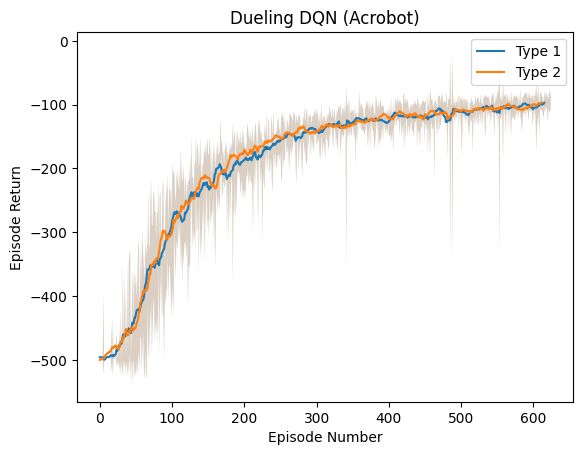

In [98]:
plot_mean_variance(scores_experiment1, scores_experiment2, window_size=10)